# Comparing with other methods for copula estimation and with different DRE methods

In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_q(data_p):
    ''' 
    Shuffle data_p dimension-zise to break dependence
    '''
    data_q = np.copy(data_p)
    n_dim = data_p.shape[1]
    for dim in range(n_dim):
        np.random.shuffle(data_q[:, dim])
    return torch.tensor(data_q)

## 1 - Using F-DRE

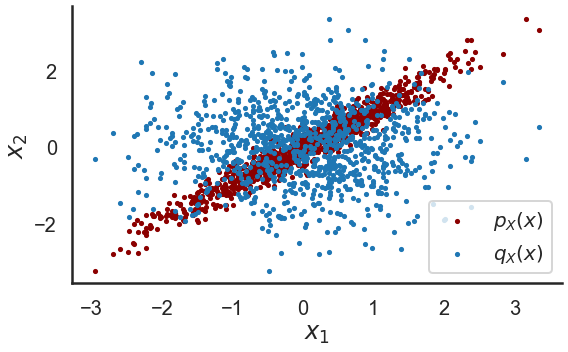

In [3]:
N = 1000
p = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0.97], [0.97, 1.0]]))
data_p = p.sample((N,))
data_q = get_q(data_p)
true_xs = torch.cat([data_p, data_q])
true_xs.shape

plt.figure(figsize=(8,5))
plt.scatter(data_p[:,0], data_p[:,1], label=r'$p_X(x)$', s=10, color='darkred')
plt.scatter(data_q[:,0], data_q[:,1], label=r'$q_X(x)$', s=10, color='tab:blue')

plt.legend(loc='lower right', fontsize=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
sns.despine()

### Train z-map

In [202]:
import os
from flows.models.maf import MAF

class MLPClassifierv2(nn.Module):
  """
  simple MLP classifier (e.g. for classifying in z-space)
  slightly deeper than MLPClassifier
  """
  def __init__(self, h_dim=100, in_dim=2):
      super(MLPClassifierv2, self).__init__()
      self.h_dim = h_dim
      self.in_dim = in_dim

      self.fc1 = nn.Linear(self.in_dim, self.h_dim)
      self.fc2 = nn.Linear(self.h_dim, self.h_dim)
      self.fc3 = nn.Linear(self.h_dim, self.h_dim)
      self.fc4 = nn.Linear(self.h_dim, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    r = self.fc4(x)

    return r

def Logistic_loss(r_p,r_q):
    '''
    Vectorised version of the logistic loss function from TRE eq(1)
    '''
    return -(r_p /(1+r_p)).log() - (1/(1+r_q)).log() 

In [205]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

flow = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)

optimizer = torch.optim.Adam(flow.parameters(), lr=0.0002, weight_decay=0.0005)
epochs = 100
loss_history = []
param_history = []

for epoch in range(epochs):  # number of epochs
    perm = torch.randperm(true_xs.size(0))
    idx = perm[:500]
    sub_samples = true_xs[idx]
    optimizer.zero_grad()
    log_prob = flow.log_prob(sub_samples)
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()
    #data_q = get_q(data_p)
    #true_xs = torch.cat([data_p, data_q])
    with torch.no_grad():
        loss_history.append(loss.item())
        param_history.append(flow._parameters)
        if epoch % round(epochs/20) == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))
            
flow.eval();


Epoch: 0, Loss: 2.7360
Epoch: 5, Loss: 2.7049
Epoch: 10, Loss: 2.5748
Epoch: 15, Loss: 2.5386
Epoch: 20, Loss: 2.5364
Epoch: 25, Loss: 2.6041
Epoch: 30, Loss: 2.5364
Epoch: 35, Loss: 2.5466
Epoch: 40, Loss: 2.5526
Epoch: 45, Loss: 2.7016
Epoch: 50, Loss: 2.5920
Epoch: 55, Loss: 2.4394
Epoch: 60, Loss: 2.4753
Epoch: 65, Loss: 2.5813
Epoch: 70, Loss: 2.4780
Epoch: 75, Loss: 2.5366
Epoch: 80, Loss: 2.5607
Epoch: 85, Loss: 2.4629
Epoch: 90, Loss: 2.6028
Epoch: 95, Loss: 2.5219


Text(0.5, 1.0, 'Training loss')

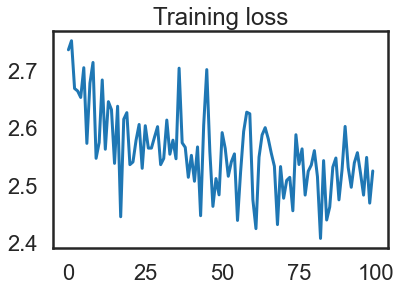

In [206]:
plt.plot(loss_history)
plt.title('Training loss')


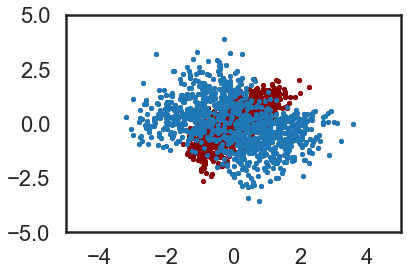

In [207]:
true_xs = torch.cat([data_p, data_q])
z_pq = flow.forward(true_xs)[0]
z_p = flow.forward(data_p)[0]
z_q = flow.forward(data_q)[0]

plt.scatter(z_pq[:,0].data.cpu().numpy(), z_pq[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='Grey')
plt.scatter(z_p[:,0].data.cpu().numpy(), z_p[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='darkred')
plt.scatter(z_q[:,0].data.cpu().numpy(), z_q[:,1].data.cpu().numpy(), label=r'$q_Z(z)$', s=10, color='tab:blue')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()
# Needed flow.eval() to turn off batch norm and dropout, in order to have same outputs for same inputs

### Train ratio function

#### X-space DRE

In [134]:
mlp_x = MLPClassifierv2(in_dim=2, h_dim=100)

optimizer = torch.optim.Adam(mlp_x.parameters(),lr=0.002,weight_decay=0.005)
steps = 100
mlp_x_loss_hisory = []
# Train 
for t in range(steps):
    torch.nn.utils.clip_grad_norm_(mlp_x.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_value_(mlp_x.parameters(), clip_value=5.0)
    optimizer.zero_grad()
    r_p = mlp_x.forward(data_p).exp()
    data_q = get_q(data_p)
    r_q = mlp_x.forward(data_q).exp()
    loss = Logistic_loss(r_p,r_q).mean() 
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        if t % round(steps/20) == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        mlp_x_loss_hisory.append(loss.item())

mlp_x.eval();

Epoch: 0, Loss: 1.3923
Epoch: 5, Loss: 1.3109
Epoch: 10, Loss: 1.2058
Epoch: 15, Loss: 1.0555
Epoch: 20, Loss: 0.9129
Epoch: 25, Loss: 0.7659
Epoch: 30, Loss: 0.7015
Epoch: 35, Loss: 0.7015
Epoch: 40, Loss: 0.7392
Epoch: 45, Loss: 0.7024
Epoch: 50, Loss: 0.7197
Epoch: 55, Loss: 0.6922
Epoch: 60, Loss: 0.7017
Epoch: 65, Loss: 0.6810
Epoch: 70, Loss: 0.7176
Epoch: 75, Loss: 0.6847
Epoch: 80, Loss: 0.7223
Epoch: 85, Loss: 0.6894
Epoch: 90, Loss: 0.7084
Epoch: 95, Loss: 0.7173


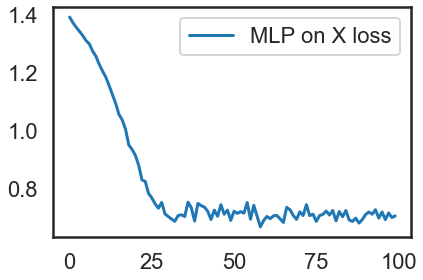

In [140]:
plt.plot(mlp_x_loss_hisory, label='MLP on X loss')
plt.legend()
plt.tight_layout()
plt.show()

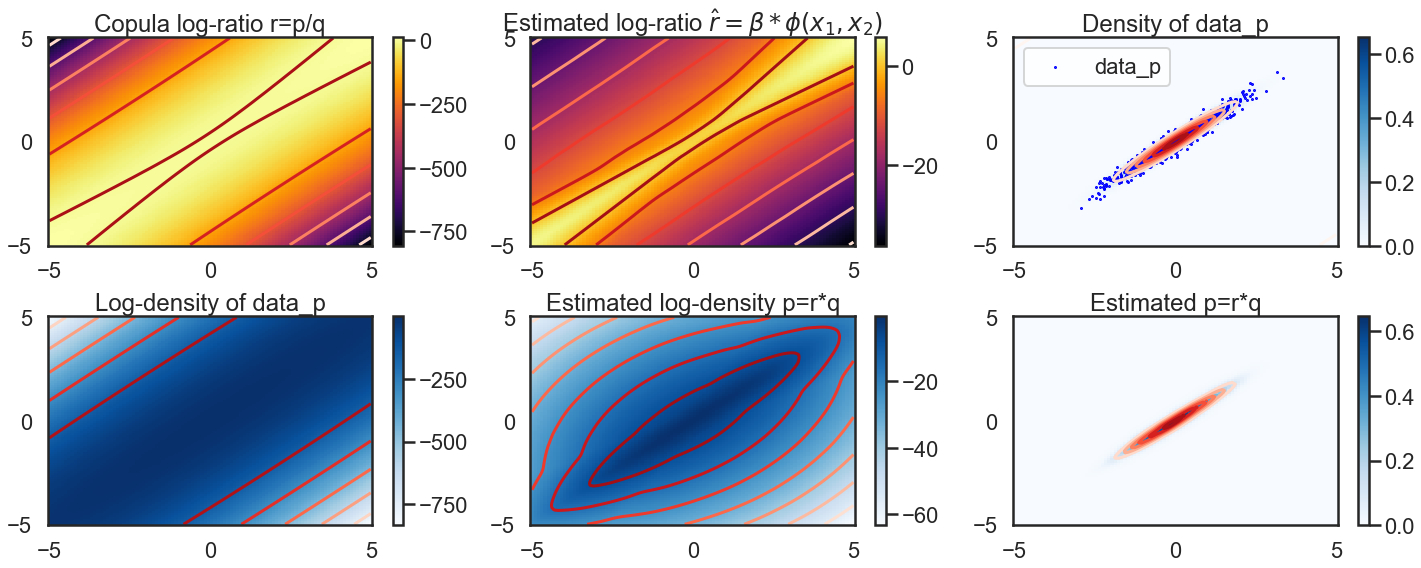

In [139]:
import scipy.stats as scs


fig, axs = plt.subplots(2, 3, figsize=(20, 8))  

xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.norm.logpdf(x = uvinput[:,0])-scs.norm.logpdf(x = uvinput[:,1])
contour_plot = axs[0,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0,0]) 
axs[0,0].contour(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='Reds')
axs[0,0].set_title('Copula log-ratio r=p/q')

# Plot of ratio 
with torch.no_grad():
    ratio = mlp_x.forward(torch.tensor(np.vstack([xgrid.ravel(), ygrid.ravel()]).T).float()).detach().numpy()
ratio_plot = axs[0,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[0,1])
axs[0,1].contour(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='Reds')
axs[0,1].set_title(r'Estimated log-ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot of joint density of data_p
density_p = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[1,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1,0])
axs[1,0].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[1,0].set_title('Log-density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,1])
axs[1,1].contour(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Reds')
axs[1,1].set_title('Estimated log-density p=r*q')

# Plot of datap
density_p = scs.multivariate_normal.pdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[0,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[0,2])
axs[0,2].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[0,2].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0,2].legend()
axs[0,2].set_title('Density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,2])
axs[1,2].contour(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Reds')
axs[1,2].set_title('Estimated p=r*q')

plt.tight_layout()
plt.show()


#### Z-space DRE

In [208]:
mlp_z = MLPClassifierv2(in_dim=2, h_dim=100)

optimizer = torch.optim.Adam(mlp_z.parameters(),lr=0.002,weight_decay=0.005)
steps = 100
mlp_z_loss_hisory = []

#Z-space transformation
with torch.no_grad():
    z_data_p = flow.forward(data_p)[0]

# Train 
for t in range(steps):
    torch.nn.utils.clip_grad_norm_(mlp_z.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_value_(mlp_z.parameters(), clip_value=5.0)
    optimizer.zero_grad()
    r_p = mlp_z.forward(z_data_p).exp()
    with torch.no_grad():
        z_data_q = flow.forward(get_q(data_p))[0]
    r_q = mlp_z.forward(z_data_q).exp()
    loss = Logistic_loss(r_p,r_q).mean() 
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        if t % round(steps/20) == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        mlp_z_loss_hisory.append(loss.item())

mlp_z.eval();

Epoch: 0, Loss: 1.3847
Epoch: 5, Loss: 1.2656
Epoch: 10, Loss: 1.1037
Epoch: 15, Loss: 0.8680
Epoch: 20, Loss: 0.7079
Epoch: 25, Loss: 0.6977
Epoch: 30, Loss: 0.7301
Epoch: 35, Loss: 0.7107
Epoch: 40, Loss: 0.7032
Epoch: 45, Loss: 0.7244
Epoch: 50, Loss: 0.6896
Epoch: 55, Loss: 0.7356
Epoch: 60, Loss: 0.7221
Epoch: 65, Loss: 0.6767
Epoch: 70, Loss: 0.7009
Epoch: 75, Loss: 0.6817
Epoch: 80, Loss: 0.7463
Epoch: 85, Loss: 0.7032
Epoch: 90, Loss: 0.7326
Epoch: 95, Loss: 0.6997


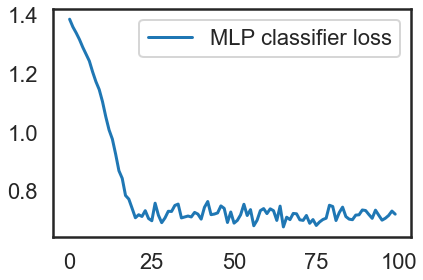

In [209]:
plt.plot(mlp_z_loss_hisory, label='MLP classifier loss')
plt.legend()
plt.tight_layout()
plt.show()

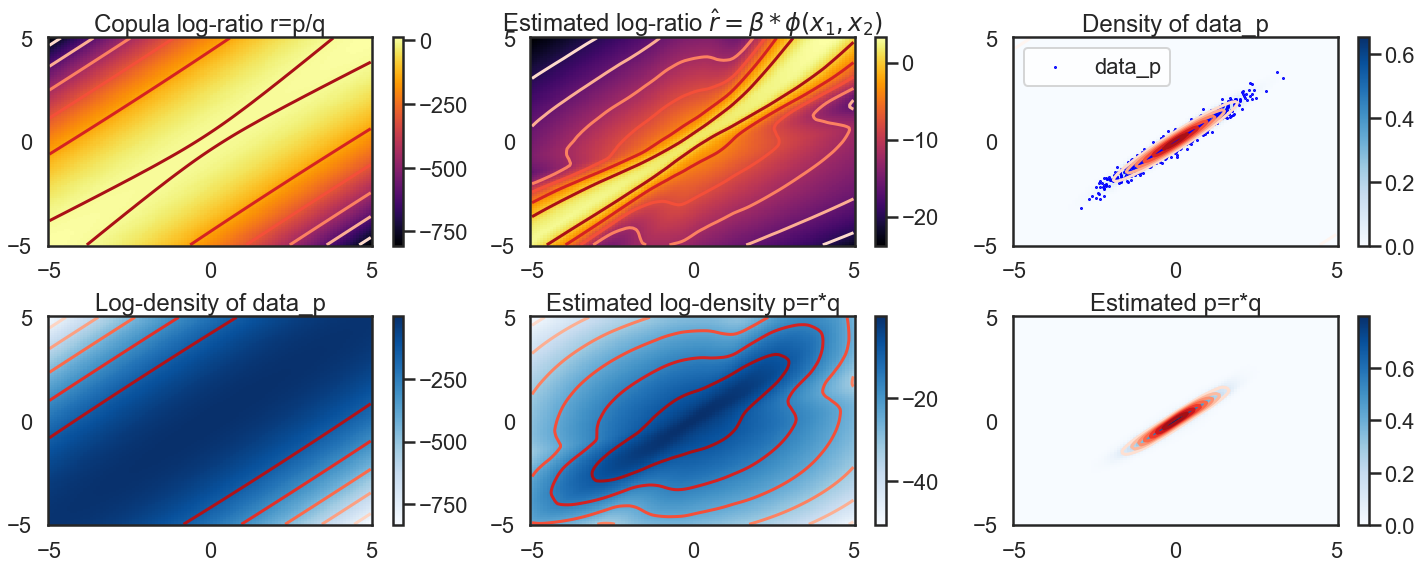

In [221]:
import scipy.stats as scs


fig, axs = plt.subplots(2, 3, figsize=(20, 8))  

xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.norm.logpdf(x = uvinput[:,0])-scs.norm.logpdf(x = uvinput[:,1])
contour_plot = axs[0,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0,0]) 
axs[0,0].contour(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='Reds')
axs[0,0].set_title('Copula log-ratio r=p/q')

# Plot of ratio 
with torch.no_grad():
    z_grid = flow.forward(torch.tensor(np.vstack([xgrid.ravel(), ygrid.ravel()]).T).float())[0]
    ratio = mlp_z.forward(z_grid).detach().numpy()
ratio_plot = axs[0,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[0,1])
axs[0,1].contour(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='Reds')
axs[0,1].set_title(r'Estimated log-ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot of joint density of data_p
density_p = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[1,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1,0])
axs[1,0].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[1,0].set_title('Log-density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,1])
axs[1,1].contour(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Reds')
axs[1,1].set_title('Estimated log-density p=r*q')

# Plot of datap
density_p = scs.multivariate_normal.pdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[0,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[0,2])
axs[0,2].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[0,2].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0,2].legend()
axs[0,2].set_title('Density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,2])
axs[1,2].contour(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Reds')
axs[1,2].set_title('Estimated p=r*q')

plt.tight_layout()
plt.show()


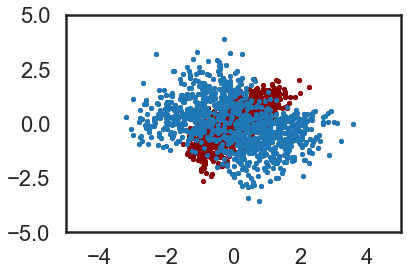

In [216]:
plt.scatter(z_pq[:,0].data.cpu().numpy(), z_pq[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='Grey')
plt.scatter(z_p[:,0].data.cpu().numpy(), z_p[:,1].data.cpu().numpy(), label=r'$p_Z(z)$', s=10, color='darkred')
plt.scatter(z_q[:,0].data.cpu().numpy(), z_q[:,1].data.cpu().numpy(), label=r'$q_Z(z)$', s=10, color='tab:blue')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

## Eigenvalue analysis of KL density-chasm

In [1]:
N=500 
mat_p = torch.tensor([[1.0, 0.9999999], [0.9999999, 1.0]])
data_p = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0.0, 0.0]), mat_p).sample((N,))
mat_q = torch.tensor([[1.0, 0], [0, 1.0]])
data_q = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0.0, 0.0]), mat_q).sample((N,))
#plot the egenvectors scaled by egenvalues
plt.scatter(data_p[:,0], data_p[:,1],s=3)
plt.scatter(data_q[:,0], data_q[:,1],s=3)
evals_p,evecs_p = torch.linalg.eigh(mat_p)
evals_q,evecs_q = torch.linalg.eigh(mat_q)
print(evecs_p,evals_p)
print(evecs_q,evals_q)
plt.quiver(0,0,evals_p[0]*evecs_p[0,0].numpy(),evals_p[0]*evecs_p[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='b')
plt.quiver(0,0,evals_p[1]*evecs_p[0,1].numpy(),evals_p[1]*evecs_p[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='b')

plt.quiver(0,0,evals_q[0]*evecs_q[0,0].numpy(),evals_q[0]*evecs_q[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.quiver(0,0,evals_q[1]*evecs_q[0,1].numpy(),evals_q[1]*evecs_q[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.show()

# now with sample covariance matrices

s_mat_p = (N+1)/N  * torch.cov(data_p.T)
s_mat_q = (N+1)/N  * torch.cov(data_q.T)
evals_p,evecs_p = torch.linalg.eigh(s_mat_p)
evals_q,evecs_q = torch.linalg.eigh(s_mat_q)
print(evecs_p,evals_p)
print(evecs_q,evals_q)
plt.scatter(data_p[:,0], data_p[:,1],s=3)
plt.scatter(data_q[:,0], data_q[:,1],s=3)

plt.quiver(0,0,evals_p[0]*evecs_p[0,0].numpy(),evals_p[0]*evecs_p[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='b')
plt.quiver(0,0,evals_p[1]*evecs_p[0,1].numpy(),evals_p[1]*evecs_p[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='b')

plt.quiver(0,0,evals_q[0]*evecs_q[0,0].numpy(),evals_q[0]*evecs_q[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.quiver(0,0,evals_q[1]*evecs_q[0,1].numpy(),evals_q[1]*evecs_q[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.show()

# now with q being a permutation of p
data_q = get_q(data_p)
s_mat_p = (N+1)/N * torch.cov(data_p.T)
s_mat_q = (N+1)/N * torch.cov(data_q.T)
evals_p,evecs_p = torch.linalg.eigh(s_mat_p)
evals_q,evecs_q = torch.linalg.eigh(s_mat_q)
print(evecs_p,evals_p)
print(evecs_q,evals_q)
plt.scatter(data_p[:,0], data_p[:,1],s=3)
plt.scatter(data_q[:,0], data_q[:,1],s=3)

plt.quiver(0,0,evals_p[0]*evecs_p[0,0].numpy(),evals_p[0]*evecs_p[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='b')
plt.quiver(0,0,evals_p[1]*evecs_p[0,1].numpy(),evals_p[1]*evecs_p[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='b')

plt.quiver(0,0,evals_q[0]*evecs_q[0,0].numpy(),evals_q[0]*evecs_q[1,0].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.quiver(0,0,evals_q[1]*evecs_q[0,1].numpy(),evals_q[1]*evecs_q[1,1].numpy(),angles='xy', scale_units='xy', scale=1,color='orange')
plt.show()


NameError: name 'torch' is not defined

In [183]:
[5.9605e-08* 1.9452e+00]

[1.15943646e-07]

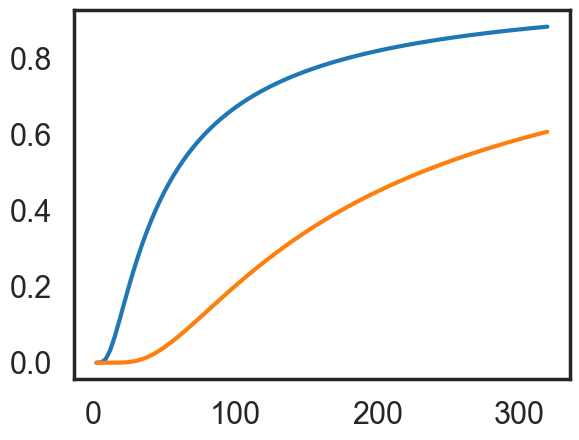

KL is < 20 for:  min_eval >= [(2.061153622438558e-09, 2.0), (0.035673993347252395, 12.0), (0.16232061118184818, 22.0), (0.2865047968601901, 32.0), (0.38582130682912413, 42.0), (0.4633693692311753, 52.0), (0.5245779259399984, 62.0), (0.5737534207374327, 72.0), (0.6139726608994069, 82.0), (0.647405392083911, 92.0)]


In [184]:
plt.plot(np.linspace(2,320,100),[(np.exp(-40/d)) for d in np.linspace(2,320,100)])
plt.plot(np.linspace(2,320,100),[(np.exp(-160/d)) for d in np.linspace(2,320,100)])

plt.show()
print('KL is < 20 for:  min_eval >=', [(np.exp(-40/d),d) for d in np.linspace(2,92,10)])